In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import nltk
import datetime
nltk.data.path.append(r"/Users/seb/Workspace/Dev/Formation-OC/LIBRAIRIES/nltk_data")

In [2]:
file1 = 'data/QueryResults3_new.csv'
df1 = pd.read_csv(file1,index_col=['Id'])

import mes_fonctions_final2 as stt

In [3]:
import imp
##from mes_fonctions import fonction_nettoyage, etape1, etape2, etape3, etape3_bis
imp.reload(stt)

<module 'mes_fonctions_final2' from '/Users/seb/Workspace/Dev/Formation-OC/Formation-Data-Scientist/Projet6-Categoriser_Automatiquement_des_Questions/NoteBooks/PROJET_A_LIVRER/mes_fonctions_final2.py'>

## Features :
> Dans un 1e temps j'ai ajouté des features pour visualiser les données transformées par 
> - parsing html
> - suppression de ponctuations
> - tokenisation (dans une colonne à part)
> - lemmmatisation

> Désormais le travail se fait en directe dans la fonction Countvectorized (via la regex identié après les tests)
> 
> Je laisse tout de même ces features visible dans ce NoteBook

> Elle ajoute les colonnes : Body_clean et Tags2

In [4]:
stt.ajoute_features(df1)

# Les Tags

## Recherche sur les regex avant utilisation en fonction
> Un problème se pose pour la prise en compte des tags ayant un tiret dans le mot

In [5]:
import re

In [6]:
u = '<java><selenium><selenium-webdriver>'
u2 = '<java><selenium><seleniumwebdriver>'

In [7]:
print(re.findall(r'<(\w+|-)>', u))

['java', 'selenium']


In [8]:
print("1", re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", u2))
print("2", re.findall(r"\w+(?:[-]\w+)*|[-.(]+|\S\w*", u2))
print("3", re.findall(r'<(\w*)>', u))
print("4", re.findall(r'<(\w+)>', u))
print("5", re.findall(r'<(\w+|\S\w*)>', u))
print("6", re.findall(r'<(\w+|[a-zA-Z-]+)>', u))

1 ['<java', '>', '<selenium', '>', '<seleniumwebdriver', '>']
2 ['<java', '>', '<selenium', '>', '<seleniumwebdriver', '>']
3 ['java', 'selenium']
4 ['java', 'selenium']
5 ['java', 'selenium']
6 ['java', 'selenium', 'selenium-webdriver']


> On ajoute donc cette regex (du test 6) pour l'identification des données de Y_tags dans le fichier mes_fonctions_final

In [9]:
Y_tags = stt.genere_target_dummy(data=df1, min_df=40)

In [10]:
Tags_freq = stt.genere_df_target_tags_freq(data=df1, min_df=40)

## Répartition du nombre de features par seuil

In [11]:
Tags_freq_test = stt.genere_df_target_tags_freq(data=df1, min_df=1)

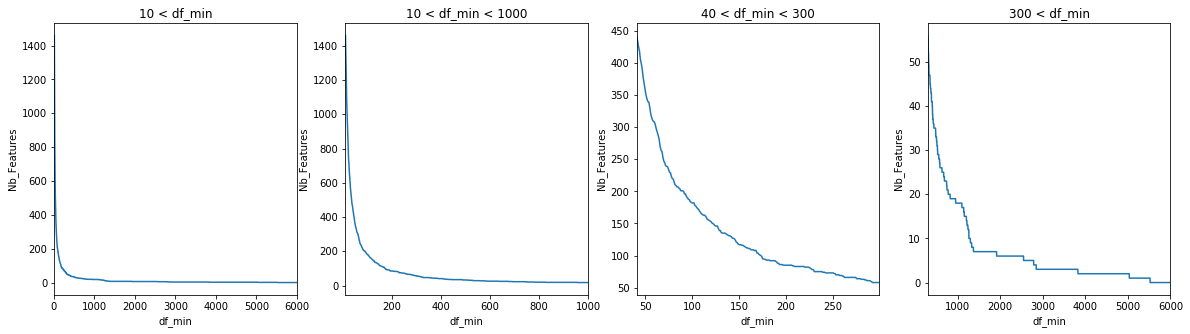

In [12]:
u = range(1,6000, 1)

res = []
for i in u:
    res.append(np.sum(Tags_freq_test.Freq>i))
    
a = pd.DataFrame({'df_min':np.array(u), 'Nb_Features':np.array(res)})

fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(141)
a[a['df_min']>10].plot(x=['df_min'], y=['Nb_Features'], ax=ax, legend=False)
plt.ylabel('Nb_Features')
plt.title('10 < df_min')

ax = fig.add_subplot(142)
a[(a['df_min']>10) & (a['df_min']<1000)].plot(x=['df_min'], y=['Nb_Features'], ax=ax, legend=False)
plt.ylabel('Nb_Features')
plt.title('10 < df_min < 1000')

ax = fig.add_subplot(143)
a[(a['df_min']>40) & (a['df_min']<300)].plot(x=['df_min'], y=['Nb_Features'], ax=ax, legend=False)
plt.ylabel('Nb_Features')
plt.title('40 < df_min < 300')

ax = fig.add_subplot(144)
a[a['df_min']>300].plot(x=['df_min'], y=['Nb_Features'], ax=ax, legend=False)
plt.ylabel('Nb_Features')
plt.title('300 < df_min')
plt.show()

> On voit qu'il y a une chute rapide du nombre de features avec l'augmentation du seuil df_min
> 
> Nous allons pouvoir nous intéresser à une valeur de 500 (soit 1% comme valeur df_min pour les 500 000 valeurs)

## Les tags les plus fréquents

In [13]:
Tags_freq.head()

,Freq
python,5522
javascript,5034
java,3827
android,2848
c#,2788


# Recherche des STOP-WORD

In [14]:
df1.head(20)[['Body', 'Body_clean']]

,Body,Body_clean
Id,,
52799725,<p>I am trying to automate the compose email f...,i am trying to automate the compose email flow...
52799724,<p>I have a website and we only have access to...,i have website and we only have access to the ...
52799719,<p>I have an html page in my local network. I ...,i have an html page in my local network need t...
52799717,<p>I have a list declared:</p>\n\n<pre><code>l...,i have list declared and want to filter the li...
52799714,<p>I have case with two results sets and i nee...,i have case with two results sets and need to ...
52799711,<p>I have 2 lists of Int of equal size (roughl...,"i have lists of int of equal size roughly 10,0..."
52799708,"<p>is my website <a href=""https://airtel-custo...",is my website airtel customer care have using ...
52799706,<p>I am new to Hibernate and SpringBoot. My pr...,i am new to hibernate and springboot my projec...
52799703,<p>Here's an image of the scanner format I use...,here's an image of the scanner format use the ...


In [15]:
u = df1.loc[52799684]['Body']
v = df1.loc[52799684]['Body_clean']

In [16]:
u

"<p>From <code>Parent</code> component, I pass domain props to <code>Child</code> component. In <code>Child</code>, if a website exists with the domain, it returns the website's information. Otherwise, it returns null. When it returns null, I don't want to render the <code>Child</code> component on <code>Parent</code> component.</p>\n\n<p>How can I prevent rendering it?</p>\n\n<pre><code>class Parent extends Component {\n\n  ...\n\n  render() {\n    const { domain } = this.props;\n    return (\n        &lt;div&gt;\n            &lt;Child domain={domain} /&gt;\n        &lt;/div&gt;\n    );\n  }\n}\n\nclass Child extends Component {\n  ...\n  Here, check if the website exists\n  ...\n\n  render() {\n    const { domain } = this.props;\n    const { isExist } = this.state;\n\n    return {isExist ? &lt;div&gt;Yes&lt;/div&gt; : null}\n  }\n\n}\n</code></pre>\n"

In [17]:
v

"from component pass domain props to component in if website exists with the domain it returns the website's information otherwise it returns null when it returns null don't want to render the component on component how can prevent rendering it "

## Création du Bag Of Word et normalisation de la matrice 
> /!\ on ne fait pas la transformation tf-idf (juste tf qui fait la normalisation des données) 

In [18]:
def get_freq_word(data, col, min_df=1):
    '''
    Cette fonction va renvoyer la frequence des mots issues du DataSet.
    C'est cette matrice qui nous servira à identifier les Stop-Words
    INPUT: 
    ------
        - data : dataSet à analyser
        - col : le nom de la colonne où se trouve le texte
        - min_df=1 : nombre minimum d'occurence des mots pour être pris en compte
    OUTPUT: 
    -------
        - Matrice normalisée Tf (fréquence des mots)
    INFORMATION:
    ------------
        - On utilise le stemming pour lemmatization 
        -> Nous pourrons remplacer cela par la lemmatization de 'Porter'        
    '''
    # Nous chargeons la fonction de comptage des features
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Partie de lemmatization
    # On charge la librairie de Stemmer en Anglais
    from nltk.stem.snowball import EnglishStemmer
    stemmer = EnglishStemmer()

    # Réalisation du stemming (on coupe les racines)
    def stem_tokens(tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed

    # La tokenisation : 
    def tokenize(text):
        m_token_pattern = r"((?:(?:(?:[0-9a-zA-Z])\.){2,}[a-zA-Z])" +\
            "|(?:(?:[0-9a-zA-Z]){2,}\.(?:[0-9a-zA-Z]){2,}" +\
            "|(?:\.(?:[0-9a-zA-Z]){2,}))" +\
            "|[0-9a-zA-Z-\-\+\#]{2,}|w+)"
        
        from nltk.tokenize import RegexpTokenizer
        # Nous allons utiliser le pattern pour identifier les mots
        tokenizer = RegexpTokenizer(m_token_pattern)
        
        # Nous lançons la séparation des mots
        tokens = tokenizer.tokenize(text)
        
        # Nous faisons appel au stemming pour rapprocher les mots de même racine
        stems = stem_tokens(tokens, stemmer)
        
        # Etape de nettoyage des valeurs :
        # Nous allons supprimer les nombres sans texte, 
        def suppress_nb(x):
            import re
            if x is None:
                return None
            pattern = r'(^[\#\-\+]*[0-9]*$|' +\
                    '^[0-9]*[\#\-\+]*$|' +\
                    '^[0-9]*[\#\-\+]?[0-9]*$|' +\
                    '^[0-9\#\-\+][a-z]$|' +\
                    '^[a-z][0-9\#\-\+]$|' +\
                    '^[0-9]*\.[0-9]*$)'
            if not(re.match(pattern, x)):
                return x
        
        def nettoie_points(x):
            import re
            if x is None:
                return None

            if (re.match(r'(^[\.\-\#][a-z]*$)', x)):
                return ''.join(list(x)[1:])
            else:
                return x

        # Nous filtrons les nombres seuls
        stems = list(filter(lambda x: suppress_nb(x), stems)) 
        stems = [nettoie_points(x) for x in stems]
        return stems


    # Le préprocessing : 
    #   - nettoie le html 
    #   - supprime les blocs de Code 
    #   - ne prend que la partie textuelle du html
    #   - renvoie ce texte en minuscule
    def preProcess(html_in):
        # Chargement du module BeautifulSoup pour le parsing des données HTML
        from bs4 import BeautifulSoup
        html_in_soup = BeautifulSoup(html_in, 'html.parser')

        # Suppression des blocs de Code
        for h_code in html_in_soup.find_all('code'):
            h_code.decompose()
        
        return html_in_soup.get_text().lower()
        
    
    
    
    # Fabrication du Bag Of Words (BOW) via CountVectorizer
    
    vectorizer = CountVectorizer(
        analyzer="word",
        # Nous pouvons faire varier la fréquence minimum pour la prise en compte des mots
        min_df=min_df,        
        tokenizer=tokenize,
        #token_pattern=m_token_pattern, 
        preprocessor=preProcess,
        stop_words=[],        # Pas de stopWord car nous les cherchons
        ngram_range=(1,1),    # Nous ne prenons que le 1-Gram
        #max_features = 1000  # Nous cherchons les nombres maximum
    ) 
    
    import datetime
    debut = datetime.datetime.now()
    
    # On entraine les données pour fabriquer le Bow
    train_data_features = vectorizer.fit_transform(data[col])
    
    fin = datetime.datetime.now()
    print("[ Vectorizer : {}]".format(fin-debut))

    # Nous allons renvoie une matrice normalisée
    #  des fréquences des mots dans chaque POST
    from sklearn.feature_extraction.text import TfidfTransformer
    debut = datetime.datetime.now()
    
    # Attention nous ne voulons pas la forme TFiDF donc use_idf=False
    tf = TfidfTransformer(use_idf=False)
    train_data_features_fitted = tf.fit_transform(train_data_features)

    fin = datetime.datetime.now()
    print("[ TfidfTransformer : {}]".format(fin-debut))
    
    # On va retourne la matrice dense de résultat
    debut = datetime.datetime.now()
    
    X = pd.DataFrame(
        data=train_data_features_fitted.toarray(), 
        columns=vectorizer.get_feature_names(),
        #default_fill_value=0
    )
    fin = datetime.datetime.now()
    print("[ DataFrame : SparseToDense {} ]".format(fin-debut))
    
    return X
    

In [19]:
# Nous n'allons prendre en compte que les mots sités au moins 20 fois 
x = get_freq_word(data=df1, col='Body', min_df=20)

[ Vectorizer : 0:01:12.652733]
[ TfidfTransformer : 0:00:00.017719]
[ DataFrame : SparseToDense 0:00:00.653285 ]


In [20]:
x.shape

(50000, 3798)

> Nous avons 3 800 mots qui peuvent être considérés comme importants

## Analyse des mots fréquents

### Répartitions des mots dans les posts
> Nous allons compter les mots présents plus d'une fois dans chaque POST


In [21]:
debut = datetime.datetime.now()

# On transforme la matrice en matrice Dense
u = pd.DataFrame(data=np.sum(x>0, axis=0), index=x.columns.tolist(), columns=['Frequence_POST'])

fin = datetime.datetime.now()
print("[ Fréquence des mots dans les POSTS : {}]".format(fin-debut))

[ Fréquence des mots dans les POSTS : 0:00:05.011587]


In [22]:
# On regarde les valeurs présentes le moins de fois 
u.sort_values(by=['Frequence_POST'], ascending=True).head()

,Frequence_POST
obstacl,20
flavor,20
setup.pi,20
boil,20
india,20


> Bien evidemmment on trouve des valeurs sitées 20 fois comme paramétrées

In [23]:
# On regarde les valeurs présentes le plus de fois 
u.sort_values(by=['Frequence_POST'], ascending=False).head(10)

,Frequence_POST
to,44795
the,43265
is,36980
and,35175
in,34144
it,30157
this,29874
of,27095
but,26914
have,26791


> Pour 50 000 POSTS la fréquence de ces mots est importante

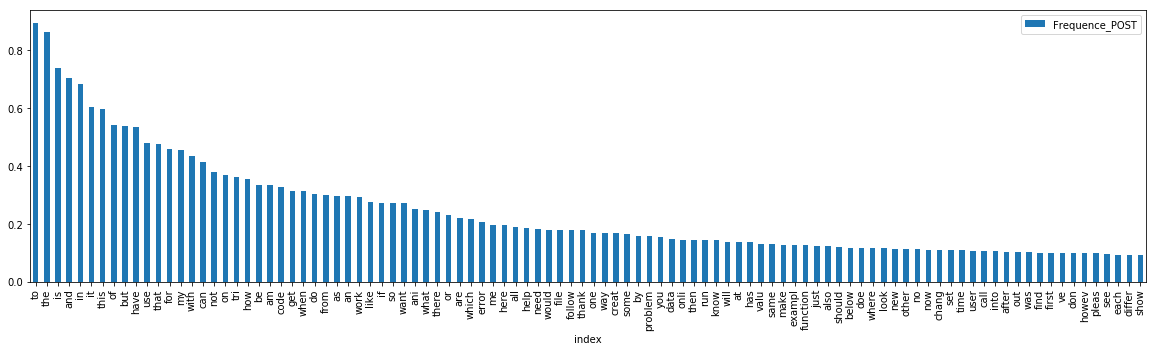

In [24]:
# Regardons les 100 valeurs les plus fréquentes 
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(100).reset_index().\
    plot.bar(x='index', y='Frequence_POST', figsize=(20,5))
plt.show()

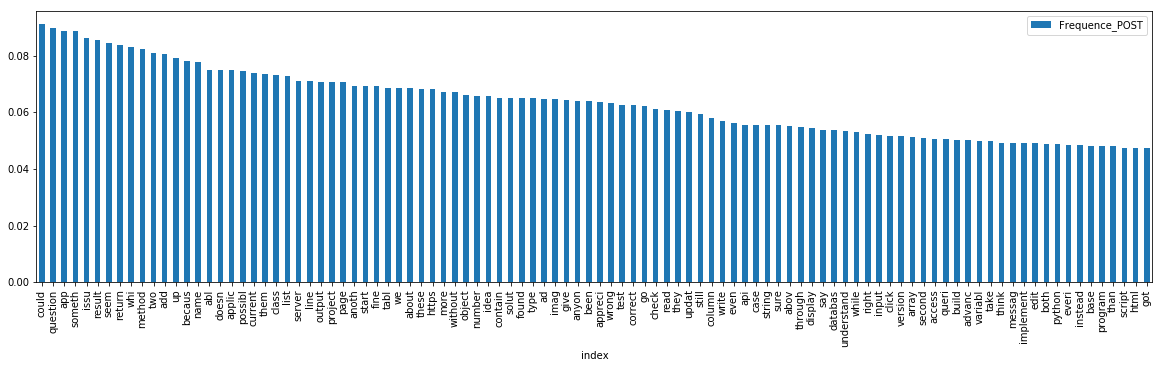

In [25]:
# Regardons les 100 valeurs suivantes
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(200).tail(100).reset_index().\
    plot.bar(x='index', y='Frequence_POST', figsize=(20,5))
plt.show()

> Il semble que les valeurs représentées dans moins de 10% nous commençons à trouver du texte lié à des particularités techniques
> - class
> - list
> - line 
> - server

> Nous allons donc fixé à 0.1 % le taux de présence dans les POST pour considérer les textes comme étant des STOP-WORD

In [26]:
Stop_Word = u2[u2.Frequence_POST>0.1].index.tolist()
print("Liste des StopWord ({} mots)\n{}".format(len(Stop_Word), Stop_Word))

Liste des StopWord (91 mots)
['to', 'the', 'is', 'and', 'in', 'it', 'this', 'of', 'but', 'have', 'use', 'that', 'for', 'my', 'with', 'can', 'not', 'on', 'tri', 'how', 'be', 'am', 'code', 'get', 'when', 'do', 'from', 'as', 'an', 'work', 'like', 'if', 'so', 'want', 'ani', 'what', 'there', 'or', 'are', 'which', 'error', 'me', 'here', 'all', 'help', 'need', 'would', 'file', 'follow', 'thank', 'one', 'way', 'creat', 'some', 'by', 'problem', 'you', 'data', 'onli', 'then', 'run', 'know', 'will', 'at', 'has', 'valu', 'same', 'make', 'exampl', 'function', 'just', 'also', 'should', 'below', 'doe', 'where', 'look', 'new', 'other', 'no', 'now', 'chang', 'set', 'time', 'user', 'call', 'into', 'after', 'out', 'was', 'find']


In [27]:
sw = set(Stop_Word)
sw.update(tuple(nltk.corpus.stopwords.words('english')))
Stop_Word = list(sw)

print("Liste des StopWord ({} mots)\n{}".format(len(Stop_Word), Stop_Word))

Liste des StopWord (216 mots)
['look', 'needn', 'new', "she's", 'set', 'no', 'onli', 'further', 've', 'not', 'being', "haven't", 'data', 'need', "you'll", 'doing', 'only', 'while', 'like', "needn't", 'of', 'whom', "you'd", 'me', "couldn't", 'ani', "didn't", 'code', 'ours', 'into', "you've", 'it', 'before', "that'll", "it's", 'be', 'if', 'hers', 'theirs', 'her', 'once', 'am', "hasn't", 'a', 'we', 'mustn', 'after', 'both', 'i', 'too', 'as', 'want', 'time', 're', 'creat', 't', 'use', 'him', 'hadn', "mustn't", 'ma', 'myself', 'yours', 'won', 'also', 'll', 'his', 'the', 'that', 'my', 'how', 'don', 'these', "wasn't", 'way', 'out', 'follow', "hadn't", 'now', 'more', 'should', 'over', "isn't", 'mightn', 'until', 'user', "you're", "won't", 'wasn', 'will', 'here', 'tri', 'did', 'again', 'all', 'on', 'd', 'error', 'has', 'under', "aren't", 'then', 'he', "mightn't", 'and', 'this', 'from', "don't", 'chang', 'have', 'themselves', 'those', 'against', 'haven', 'so', 'make', 'up', 'where', 'your', 'you

# Analyse des N_grams :
Nous allons relancer l'analyse précedente en ajoutant les stopWord

Cette fois ci nous allons ajouter les N_grammes possibles avec des mots présents de 1 à 6 

In [28]:
def get_freq_word_with_nGrams(data, col, sw=[], min_df=1):
    '''
    Cette fonction va renvoyer la frequence des mots issues du DataSet.
    Nous mettons en paramètre les STopWords identifiés
    Nous faisons une recherche sur les N-Grams de 1 à 6
    INPUT: 
    ------
        - data : dataSet à analyser
        - col : le nom de la colonne où se trouve le texte
        - sw : liste des stopwords
        - min_df=1 : nombre minimum d'occurence des mots pour être pris en compte
    OUTPUT: 
    -------
        - Matrice normalisée Tf (fréquence des mots)
    INFORMATION:
    ------------
        - On utilise le stemming pour lemmatization 
        -> Nous pourrons remplacer cela par la lemmatization de 'Porter'        
    '''
    # Nous chargeons la fonction de comptage des features
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Partie de lemmatization
    # On charge la librairie de Stemmer en Anglais
    from nltk.stem.snowball import EnglishStemmer
    stemmer = EnglishStemmer()

    # Réalisation du stemming (on coupe les racines)
    def stem_tokens(tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed

    # La tokenisation : 
    def tokenize(text):
        m_token_pattern = r"((?:(?:(?:[0-9a-zA-Z])\.){2,}[a-zA-Z])" +\
            "|(?:(?:[0-9a-zA-Z]){2,}\.(?:[0-9a-zA-Z]){2,}" +\
            "|(?:\.(?:[0-9a-zA-Z]){2,}))" +\
            "|[0-9a-zA-Z-\-\+\#]{2,}|w+)"
        
        from nltk.tokenize import RegexpTokenizer
        # Nous allons utiliser le pattern pour identifier les mots
        tokenizer = RegexpTokenizer(m_token_pattern)
        
        # Nous lançons la séparation des mots
        tokens = tokenizer.tokenize(text)
        
        # Nous faisons appel au stemming pour rapprocher les mots de même racine
        stems = stem_tokens(tokens, stemmer)
        
        # Etape de nettoyage des valeurs :
        # Nous allons supprimer les nombres sans texte, 
        def suppress_nb(x):
            import re
            if x is None:
                return None
            pattern = r'(^[\#\-\+]*[0-9]*$|' +\
                    '^[0-9]*[\#\-\+]*$|' +\
                    '^[0-9]*[\#\-\+]?[0-9]*$|' +\
                    '^[0-9\#\-\+][a-z]$|' +\
                    '^[a-z][0-9\#\-\+]$|' +\
                    '^[0-9]*\.[0-9]*$)'
            if not(re.match(pattern, x)):
                return x
        
        def nettoie_points(x):
            import re
            if x is None:
                return None

            if (re.match(r'(^[\.\-\#][a-z]*$)', x)):
                return ''.join(list(x)[1:])
            else:
                return x
        
        # Nous filtrons les nombres seuls
        stems = list(filter(lambda x: suppress_nb(x), stems)) 
        stems = [nettoie_points(x) for x in stems]
        return stems



    # Le préprocessing : 
    #   - nettoie le html 
    #   - supprime les blocs de Code 
    #   - ne prend que la partie textuelle du html
    #   - renvoie ce texte en minuscule
    def preProcess(html_in):
        # Chargement du module BeautifulSoup pour le parsing des données HTML
        from bs4 import BeautifulSoup
        html_in_soup = BeautifulSoup(html_in, 'html.parser')

        # Suppression des blocs de Code
        for h_code in html_in_soup.find_all('code'):
            h_code.decompose()
        
        return html_in_soup.get_text().lower()
        
    
    
    
    # Fabrication du Bag Of Words (BOW) via CountVectorizer
    
    vectorizer = CountVectorizer(
        analyzer="word",
        # Nous pouvons faire varier la fréquence minimum pour la prise en compte des mots
        min_df=min_df,        
        tokenizer=tokenize,
        #token_pattern=m_token_pattern, 
        preprocessor=preProcess,
        stop_words=sw,        # Pas de stopWord car nous les cherchons
        ngram_range=(1,6),    # Nous ne prenons que le 1-Gram
        #max_features = 1000  # Nous cherchons les nombres maximum
    ) 
    
    import datetime
    debut = datetime.datetime.now()
    
    # On entraine les données pour fabriquer le Bow
    train_data_features = vectorizer.fit_transform(data[col])
    
    fin = datetime.datetime.now()
    print("[ Vectorizer : {}]".format(fin-debut))

    # Nous allons renvoie une matrice normalisée
    #  des fréquences des mots dans chaque POST
    from sklearn.feature_extraction.text import TfidfTransformer
    debut = datetime.datetime.now()
    
    # Attention nous ne voulons pas la forme TFiDF donc use_idf=False
    tf = TfidfTransformer(use_idf=False)
    train_data_features_fitted = tf.fit_transform(train_data_features)

    fin = datetime.datetime.now()
    print("[ TfidfTransformer : {}]".format(fin-debut))
    
    # On va retourne la matrice dense de résultat
    debut = datetime.datetime.now()
    
    X = pd.DataFrame(
        data=train_data_features_fitted.toarray(), 
        columns=vectorizer.get_feature_names(),
        #default_fill_value=0
    )
    fin = datetime.datetime.now()
    print("[ DataFrame : SparseToDense {} ]".format(fin-debut))
    
    return X
    

In [29]:
def get_vocabulary_with_nGrams(data, col, sw=[], min_df=1):
    '''
    Cette fonction va renvoyer le vocabulaire du DataSet.
    Nous mettons en paramètre les STopWords identifiés
    Nous faisons une recherche sur les N-Grams de 1 à 6
    INPUT: 
    ------
        - data : dataSet à analyser
        - col : le nom de la colonne où se trouve le texte
        - sw : liste des stopwords
        - min_df=1 : nombre minimum d'occurence des mots pour être pris en compte
    OUTPUT: 
    -------
        - vocabulaire identifié
    INFORMATION:
    ------------
        - On utilise le stemming pour lemmatization 
        -> Nous pourrons remplacer cela par la lemmatization de 'Porter'        
    '''
    # Nous chargeons la fonction de comptage des features
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Partie de lemmatization
    # On charge la librairie de Stemmer en Anglais
    from nltk.stem.snowball import EnglishStemmer
    stemmer = EnglishStemmer()

    # Réalisation du stemming (on coupe les racines)
    def stem_tokens(tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed

    # La tokenisation : 
    def tokenize(text):
        m_token_pattern = r"((?:(?:(?:[0-9a-zA-Z])\.){2,}[a-zA-Z])" +\
            "|(?:(?:[0-9a-zA-Z]){2,}\.(?:[0-9a-zA-Z]){2,}" +\
            "|(?:\.(?:[0-9a-zA-Z]){2,}))" +\
            "|[0-9a-zA-Z-\-\+\#]{2,}|w+)"
        
        from nltk.tokenize import RegexpTokenizer
        # Nous allons utiliser le pattern pour identifier les mots
        tokenizer = RegexpTokenizer(m_token_pattern)
        
        # Nous lançons la séparation des mots
        tokens = tokenizer.tokenize(text)
        
        # Nous faisons appel au stemming pour rapprocher les mots de même racine
        stems = stem_tokens(tokens, stemmer)
        
        # Etape de nettoyage des valeurs :
        # Nous allons supprimer les nombres sans texte, 
        def suppress_nb(x):
            import re
            if x is None:
                return None
            pattern = r'(^[\#\-\+]*[0-9]*$|' +\
                    '^[0-9]*[\#\-\+]*$|' +\
                    '^[0-9]*[\#\-\+]?[0-9]*$|' +\
                    '^[0-9\#\-\+][a-z]$|' +\
                    '^[a-z][0-9\#\-\+]$|' +\
                    '^[0-9]*\.[0-9]*$)'
            if not(re.match(pattern, x)):
                return x
        
        def nettoie_points(x):
            import re
            if x is None:
                return None

            if (re.match(r'(^[\.\-\#][a-z]*$)', x)):
                return ''.join(list(x)[1:])
            else:
                return x
        
        # Nous filtrons les nombres seuls
        stems = list(filter(lambda x: suppress_nb(x), stems)) 
        stems = [nettoie_points(x) for x in stems]
        return stems



    # Le préprocessing : 
    #   - nettoie le html 
    #   - supprime les blocs de Code 
    #   - ne prend que la partie textuelle du html
    #   - renvoie ce texte en minuscule
    def preProcess(html_in):
        # Chargement du module BeautifulSoup pour le parsing des données HTML
        from bs4 import BeautifulSoup
        html_in_soup = BeautifulSoup(html_in, 'html.parser')

        # Suppression des blocs de Code
        for h_code in html_in_soup.find_all('code'):
            h_code.decompose()
        
        return html_in_soup.get_text().lower()
        
    
    
    
    # Fabrication du Bag Of Words (BOW) via CountVectorizer
    
    vectorizer = CountVectorizer(
        analyzer="word",
        # Nous pouvons faire varier la fréquence minimum pour la prise en compte des mots
        min_df=min_df,        
        tokenizer=tokenize,
        #token_pattern=m_token_pattern, 
        preprocessor=preProcess,
        stop_words=sw,        # Pas de stopWord car nous les cherchons
        ngram_range=(1,6),    # Nous ne prenons que le 1-Gram
        #max_features = 1000  # Nous cherchons les nombres maximum
    ) 
    
    import datetime
    debut = datetime.datetime.now()
    
    # On entraine les données pour fabriquer le Bow
    train_data_features = vectorizer.fit_transform(data[col])
    
    fin = datetime.datetime.now()
    print("[ Vectorizer : {}]".format(fin-debut))

    return vectorizer.vocabulary_

In [30]:
# Nous n'allons prendre en compte que les mots sités au moins 20 fois 
x2 = get_freq_word_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=20)

[ Vectorizer : 0:01:42.050511]
[ TfidfTransformer : 0:00:00.011945]
[ DataFrame : SparseToDense 0:00:01.040514 ]


In [31]:
x2.shape

(50000, 8470)

> Il doit y avoir des N_Grams ajoutés car nous avons beaucoup plus de données que précedemment

In [32]:
debut = datetime.datetime.now()

# On transforme la matrice en matrice Dense
u = pd.DataFrame(data=np.sum(x2>0, axis=0), index=x2.columns.tolist(), columns=['Frequence_POST'])

fin = datetime.datetime.now()
print("[ Fréquence des mots dans les POSTS : {}]".format(fin-debut))

[ Fréquence des mots dans les POSTS : 0:00:12.058444]


In [33]:
# On regarde les valeurs présentes le plus de fois 
u.sort_values(by=['Frequence_POST'], ascending=False).head(10)

,Frequence_POST
first,4984
howev,4951
pleas,4928
see,4844
differ,4632
show,4584
could,4566
question,4489
app,4437
someth,4430


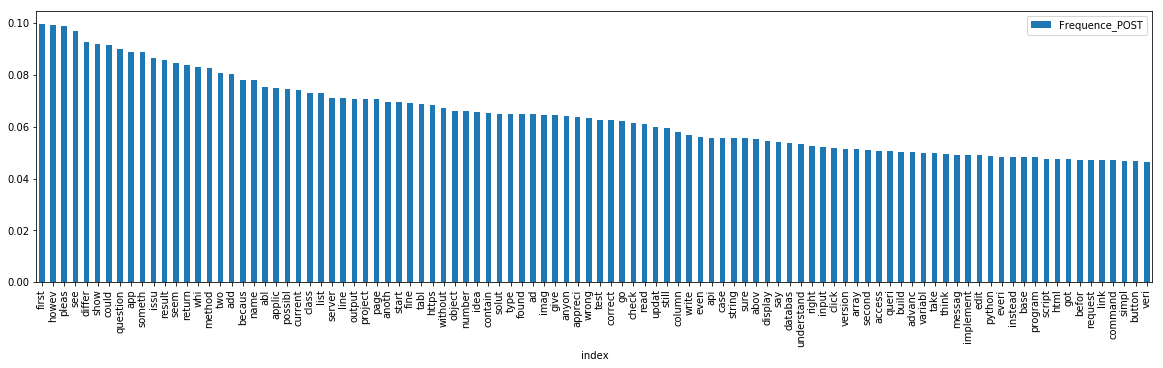

In [34]:
# Regardons les 100 valeurs les plus fréquentes 
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(100).reset_index().\
    plot.bar(x='index', y='Frequence_POST', figsize=(20,5))
plt.show()

In [35]:
x2.head()

,10k,10th,1st,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2gb,2nd,32-bit,...,yyyi,z-index,zero,zip,zone,zoom,zygoteinit,zygoteinit main,zygoteinit main zygoteinit.java,zygoteinit.java
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.149071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Identification des N_grams ajoutés : (ayant plus d'1 mot)

In [36]:
x2.columns

Index(['10k', '10th', '1st', '2018-10-08', '2018-10-09', '2018-10-10',
       '2018-10-11', '2gb', '2nd', '32-bit',
       ...
       'yyyi', 'z-index', 'zero', 'zip', 'zone', 'zoom', 'zygoteinit',
       'zygoteinit main', 'zygoteinit main zygoteinit.java',
       'zygoteinit.java'],
      dtype='object', length=8470)

In [37]:
def isNgram(value, nb_value=1):
    if len(value.split())>=nb_value:
        return value

In [38]:
nb_mots_min =2
u2 = u.loc[list(filter(lambda x: isNgram(x, nb_value=nb_mots_min), x2.columns))]
u2.sort_values(by=['Frequence_POST'], ascending=False).head(10)

,Frequence_POST
https github.com,664
great appreci,613
let say,586
visual studio,512
miss someth,457
even though,445
understand whi,425
everyth fine,407
much appreci,402
click button,394


> On constate que nous avons des verbes 've' 'don' qui ont été stemmizés

## On place la limite d'occurence de mots de 20 à 50

In [39]:
# Nous n'allons prendre en compte que les mots sités au moins 50 fois 
x3 = get_freq_word_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=50)

[ Vectorizer : 0:01:41.290747]
[ TfidfTransformer : 0:00:00.011253]
[ DataFrame : SparseToDense 0:00:00.519000 ]


In [40]:
x3.shape

(50000, 3094)

In [41]:
debut = datetime.datetime.now()

# On transforme la matrice en matrice Dense
u = pd.DataFrame(data=np.sum(x3>0, axis=0), index=x3.columns.tolist(), columns=['Frequence_POST'])

fin = datetime.datetime.now()
print("[ Fréquence des mots dans les POSTS : {}]".format(fin-debut))

# On regarde les valeurs présentes le plus de fois 
u.sort_values(by=['Frequence_POST'], ascending=False).head(10)

[ Fréquence des mots dans les POSTS : 0:00:04.059828]


,Frequence_POST
first,4984
howev,4951
pleas,4928
see,4844
differ,4632
show,4584
could,4566
question,4489
app,4437
someth,4430


> On visualise les 3_Grams les plus fréquents

In [42]:
nb_mots_min = 3
u2 = u.loc[list(filter(lambda x: isNgram(x, nb_value=nb_mots_min), x2.columns))]
u2.sort_values(by=['Frequence_POST'], ascending=False).head(10)

,Frequence_POST
enter imag descript,253.0
point right direct,152.0
cannot read properti,77.0
https docs.microsoft com,72.0
could someon pleas,71.0
spring boot applic,70.0
docs.microsoft com en-us,69.0
https docs.microsoft com en-us,69.0
stack imgur com,66.0
https stack imgur,65.0


# On reprend les mêmes analyse sur les Titres

[ Vectorizer : 0:00:15.422015]
[ TfidfTransformer : 0:00:00.004210]
[ DataFrame : SparseToDense 0:00:00.271122 ]
[ Fréquence des mots dans les POSTS : 0:00:01.636992]
La taille du dataSet est 1623


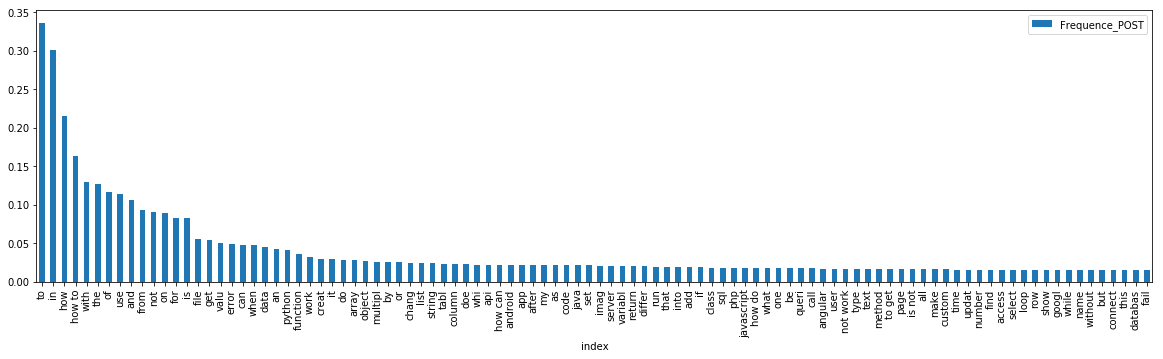

In [43]:
# Nous n'allons prendre en compte que les mots sités au moins 50 fois 
x2 = get_freq_word_with_nGrams(data=df1, col='Title', sw=[], min_df=50)

debut = datetime.datetime.now()

# On transforme la matrice en matrice Dense
u = pd.DataFrame(data=np.sum(x2>0, axis=0), index=x2.columns.tolist(), columns=['Frequence_POST'])

fin = datetime.datetime.now()
print("[ Fréquence des mots dans les POSTS : {}]".format(fin-debut))
print('La taille du dataSet est {}'.format(x2.shape[1]))
# Regardons les 100 valeurs les plus fréquentes 
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(100).reset_index().\
    plot.bar(x='index', y='Frequence_POST', figsize=(20,5))
plt.show()

[ Vectorizer : 0:00:13.735096]
[ TfidfTransformer : 0:00:00.002680]
[ DataFrame : SparseToDense 0:00:00.140861 ]
[ Fréquence des mots dans les POSTS : 0:00:00.731346]
Le nombre de feature est 983


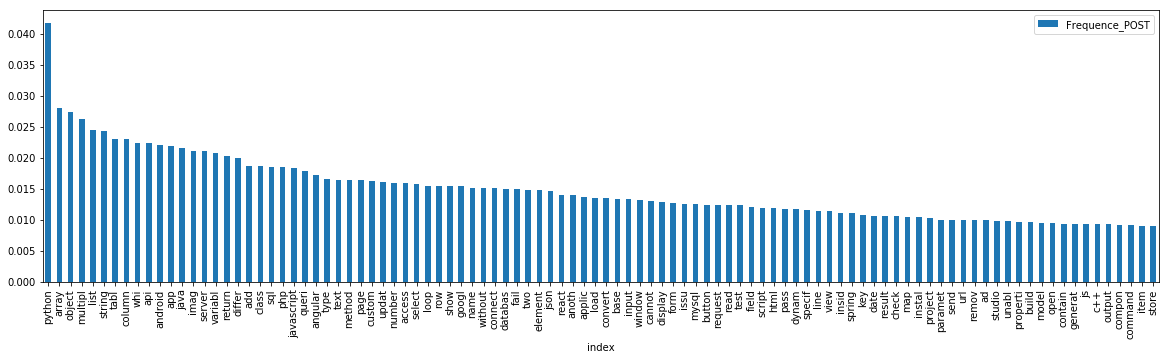

In [44]:
# Nous n'allons prendre en compte que les mots sités au moins 50 fois 
x2 = get_freq_word_with_nGrams(data=df1, col='Title', sw=Stop_Word, min_df=50)

debut = datetime.datetime.now()

# On transforme la matrice en matrice Dense
u = pd.DataFrame(data=np.sum(x2>0, axis=0), index=x2.columns.tolist(), columns=['Frequence_POST'])

fin = datetime.datetime.now()
print("[ Fréquence des mots dans les POSTS : {}]".format(fin-debut))
print('Le nombre de feature est {}'.format(x2.shape[1]))
# Regardons les 100 valeurs les plus fréquentes 
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(100).reset_index().\
    plot.bar(x='index', y='Frequence_POST', figsize=(20,5))
plt.show()

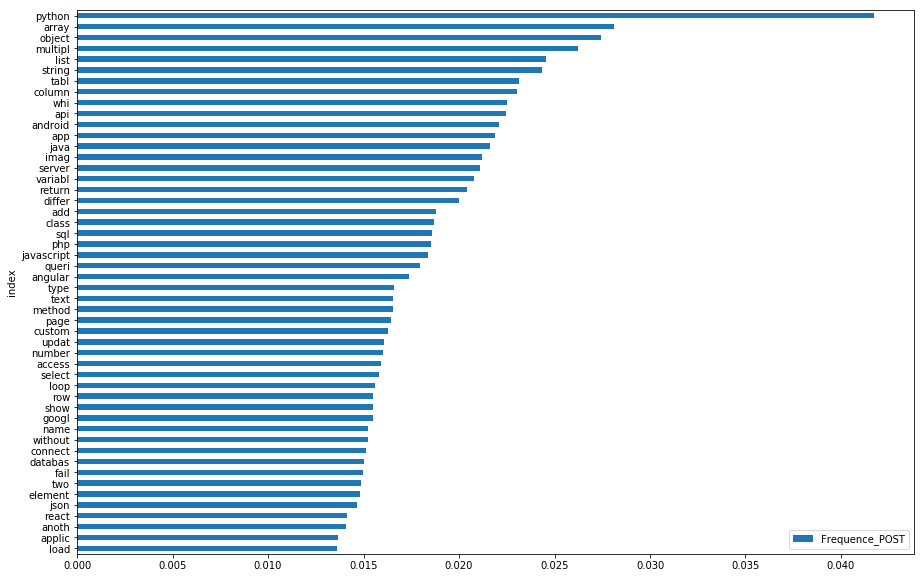

In [45]:
u2 = u.sort_values(by=['Frequence_POST'], ascending=False)/50000
u2.head(50).reset_index().\
    plot.barh(x='index', y='Frequence_POST', figsize=(15,10), )
plt.gca().invert_yaxis()
plt.yticks(fontsize=10)
plt.show()

> On se rend compte que les mots les plus représentés dans les titres (hormi les stopword) sont des mots qui soit correspondent aux Tags soit à des mots très liés

> C'est une source d'information très importante pour notre identification des tags

In [46]:
print(x2.columns.tolist()[:20])

['abl', 'accept', 'access', 'account', 'across', 'action', 'activ', 'ad', 'adapt', 'add', 'addit', 'address', 'admin', 'aggreg', 'ajax', 'alert', 'algorithm', 'align', 'allow', 'alreadi']


# Sauvegarde des données 
> Nous sauvegarde les vocabulaires créés par notre analyse

In [47]:
# générons proprement les vocabulaires de Body et de Title
voc_body = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=50)
voc_title = stt.get_vocabulary_with_nGrams(data=df1, col='Title', sw=Stop_Word, min_df=50)

[ Vectorizer : 0:01:42.317115]
[ Vectorizer : 0:00:12.600483]


In [48]:
# Les vocabulaires sont des int64 
# (non pris en charge dans le dump json )
# On les transforme avant sauvegarde
def dic_int64_to_int(dic):
    for k,v in dic.items():
        dic[k] = int(v)
    return dic

In [50]:
# On sauvegarde les StopWord
stt.save_stop_word(Stop_Word)

# On sauvegarde le vocabulaire du 'Body'
stt.save_dict(
    m_dict=dic_int64_to_int(voc_body), 
    path='data2/vocabulary_body.voc'
)

# On sauvegarde le vocabulaire du 'Body'
stt.save_dict(
    m_dict=dic_int64_to_int(voc_title), 
    path='data2/vocabulary_title.voc'
)


In [51]:
# Nous ajoutons un vocabulaire qui réuni les 2 
voc_mixte = voc_body.copy()

diff_voc = set(voc_title)-set(voc_body)
idx = max(voc_body.values())
for key in diff_voc:
    idx += 1
    voc_mixte[key] = idx
    
# On sauvegarde le vocabulaire 'Mixte'
stt.save_dict(m_dict=voc_mixte, path='data2/vocabulary_mixte.voc')

# Test sur les impacts de la suppression du bloc 'Code'
> Différence entre les vocabulaire avec ou sans le bloc Code

In [52]:
voc_body1 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=50, isCodeRemoved=True)
voc_body2 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=50, isCodeRemoved=False)

len(voc_body1), len(voc_body2)

[ Vectorizer : 0:01:42.174300]
[ Vectorizer : 0:03:30.576368]


(3094, 8118)

In [53]:
len(voc_body1), len(voc_body2)

(3094, 8118)

In [54]:
tt = set(voc_body2)-set(voc_body1)
tt

{'graviti center android',
 'year year',
 'super.viewdidload',
 'looper loop looper.java android.app activitythread',
 'caught',
 'name main main',
 'mar',
 'mylist',
 'link rel stylesheet href',
 'java.lang classnotfoundexcept',
 'www.w3 org xmlschema-inst xsi schemaloc http',
 'ns',
 'threadpoolexecutor.java java.util',
 'androidruntim',
 'amazonaw com',
 'snap',
 'scope depend depend',
 'api endpoint',
 'minsdkvers',
 'scanner public',
 'android.view',
 'respons status',
 'text html charset',
 'script script src https',
 'pk',
 'xmlns http maven.apach org pom xmlns',
 'color green',
 'curlopt',
 'string dim',
 'div section',
 'xmlns android http schemas.android com',
 'system.net',
 'androidtestimplement com.android',
 'iostream namespac std',
 'returntransf',
 'messagebox.show',
 'view.onclicklisten overrid public void',
 'httpservletrequest',
 'count++',
 'getlin',
 'td tr',
 'div ul',
 'android.app',
 'httpurlconnect',
 'dbname',
 'next button',
 'bg',
 'settitl',
 'v-for',
 'est

> Les mots et N-grams qui ressortent sont des mots important et discriminant il faut donc bien prendre en compte les informations contenues dans le bloc Code

> On peut estimer le nombre de mots de différence impacter par la limitation minimum d'occurence dans le cas de la suppression ou non du Code Bloc

In [56]:
voc_body11 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=200, isCodeRemoved=True)
voc_body21 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=200, isCodeRemoved=False)

len(voc_body11), len(voc_body21)

[ Vectorizer : 0:01:47.689265]
[ Vectorizer : 0:03:31.633079]


(1117, 1975)

In [57]:
voc_body11 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=400, isCodeRemoved=True)
voc_body21 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=400, isCodeRemoved=False)

len(voc_body11), len(voc_body21)

[ Vectorizer : 0:01:45.116678]
[ Vectorizer : 0:03:35.916941]


(682, 1062)

In [58]:
tt = set(voc_body21)-set(voc_body11)
tt

{'absolut',
 'adapt',
 'alert',
 'algorithm',
 'anim',
 'annot',
 'apach',
 'append',
 'applic json',
 'area',
 'arg',
 'arraylist',
 'articl',
 'asset',
 'associ',
 'async',
 'attr',
 'auth',
 'author',
 'auto',
 'await',
 'background-color',
 'bash',
 'batch',
 'bin',
 'binari',
 'black',
 'blue',
 'bodi html',
 'book',
 'bool',
 'boolean',
 'boot',
 'bootstrap',
 'border',
 'br',
 'btn',
 'buffer',
 'bug',
 'bundl',
 'button class',
 'button click',
 'button div',
 'byte',
 'cach',
 'callback',
 'card',
 'cast',
 'catch',
 'catch except',
 'categori',
 'center',
 'char',
 'charset',
 'charset utf-8',
 'children',
 'class btn',
 'clean',
 'click button',
 'cluster',
 'cmd',
 'col',
 'commit',
 'compani',
 'confirm',
 'consist',
 'console.log',
 'const',
 'constant',
 'constraint',
 'construct',
 'constructor',
 'contact',
 'content-typ',
 'countri',
 'cout',
 'credenti',
 'cursor',
 'datetim',
 'decid',
 'decod',
 'def',
 'desc',
 'describ',
 'desktop',
 'determin',
 'dev',
 'df',
 '

In [59]:
voc_body11 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=1000, isCodeRemoved=True)
voc_body21 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=1000, isCodeRemoved=False)

len(voc_body11), len(voc_body21)

[ Vectorizer : 0:01:43.404633]
[ Vectorizer : 0:03:26.962348]


(305, 468)

In [60]:
tt = set(voc_body21)-set(voc_body11)
tt

{'account',
 'action',
 'address',
 'angular',
 'arg',
 'argument',
 'assign',
 'attribut',
 'automat',
 'background',
 'bin',
 'bit',
 'block',
 'bodi',
 'boolean',
 'break',
 'calcul',
 'catch',
 'center',
 'charact',
 'clear',
 'close',
 'color',
 'comput',
 'condit',
 'config',
 'console.log',
 'const',
 'constructor',
 'context',
 'core',
 'count',
 'css',
 'db',
 'debug',
 'def',
 'descript',
 'devic',
 'div',
 'div class',
 'div div',
 'doc',
 'dynam',
 'echo',
 'els',
 'email',
 'enabl',
 'encod',
 'environ',
 'exit',
 'export',
 'extend',
 'fals',
 'featur',
 'fetch',
 'fill',
 'filter',
 'final',
 'foreach',
 'full',
 'group',
 'head',
 'header',
 'height',
 'home',
 'host',
 'href',
 'i++',
 'img',
 'info',
 'init',
 'int',
 'integ',
 'intern',
 'invalid',
 'io',
 'join',
 'label',
 'layout',
 'learn',
 'left',
 'length',
 'lib',
 'limit',
 'localhost',
 'login',
 'long',
 'manual',
 'max',
 'mode',
 'modifi',
 'none',
 'normal',
 'null',
 'occur',
 'ok',
 'org',
 'overrid',

In [61]:
voc_body11 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=0.015, isCodeRemoved=True)
voc_body21 = stt.get_vocabulary_with_nGrams(data=df1, col='Body', sw=Stop_Word, min_df=0.015, isCodeRemoved=False)

len(voc_body11), len(voc_body21)

[ Vectorizer : 0:01:41.148593]
[ Vectorizer : 0:03:23.843847]


(389, 612)

## Ajout d'un quartile d'expérience des Utilisateurs
> En parallèle nous avons identifié sur plus de données un plus grand nombre de valeurs avec les informations sur le nombre de Posts créés par les utilisateurs.
> 
> Nous les avons qualifié par quartile de nombre d'utilisations et nommés en 'Q1' / 'Q2' / 'Q3' / 'Q4'
>
> Q1 représente donc les utilisateurs les moins expérimentés

In [66]:
df1['Quartile_Owner_Nb_Create_Diff_Post'].value_counts()

Q1    13800
Q4    12507
Q2    12379
Q3    11314
Name: Quartile_Owner_Nb_Create_Diff_Post, dtype: int64